In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
recall_score, f1_score, log_loss, confusion_matrix, \
    classification_report, roc_curve, auc, precision_recall_curve

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

RAND = 10

# Лабораторная работа 

# Задача:
Компания, которая активно занимается Big Data и Data Science, хочет нанять специалистов по анализу данных среди людей, которые успешно проходят ее курсы. Многие люди регистрируются на обучение и компания хочет понимать, кто из этих кандидатов действительно хочет работать в компании после обучения или поиска новой работы, потому что это помогает снизить стоимость и время, а также повысить качество обучения, оптимизировать расписание курсов, понимать портрет кандидата. 


- enrolle_id - Уникальный идентификатор кандидата
- city - Код города
- city_ development _index - Индекс развития города (масштабированный)
- gender - пол кандидата
- relevent_experience - релевантный опыт кандидата
- enrolled_university - тип обучения в университете (если был)
- education_level - уровень образования кандидата
- major_discipline - основная специальность по образованию
- experience - общий стаж кандидата в годах
- company_size - размер компании в работниках
- company_type - тип работодателя
- lastnewjob - дельта в годах между предыдущей и текущей работах
- training_hours - кол-во завершенных часов обучения
- target 0 – Не ищу новую работу
- target 1 – Ищу новую работу



Спрогнозировать вероятность того, что кандидат будет искать новую работу или будет работать в компании (0 - не ищу новую работу), а также интерпретировать features при принятии решения сотрудника.

### Блок о изучении данных и статистики

In [8]:
df = pd.read_csv('/Users/sergejsilantev/Downloads/archive/aug_train.csv')

In [9]:
df[:5]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


- Код рассчитывает долю пропущенных значений для каждого столбца, где есть пропуски, по отношению к общему числу строк в датафрейме.

In [13]:
df.isna().sum()[df.isna().sum() > 0] / df.shape[0]

Series([], dtype: float64)

- Заполнения пропусков модой.

In [11]:
df.fillna(df.mode().iloc[0], inplace=True)

- Визуализация целевой переменной.

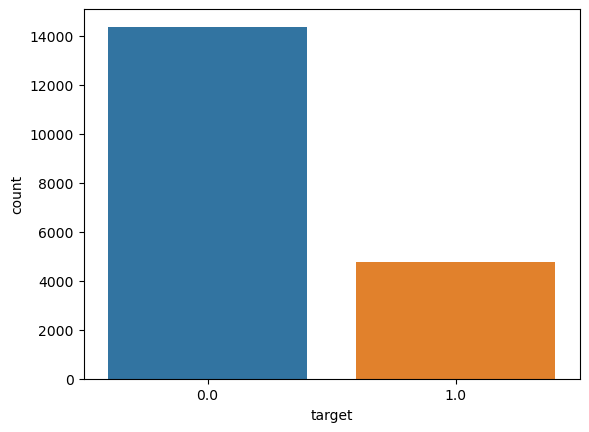

In [12]:
sns.countplot(x='target', data=df);

-  Используется для заполнения пропущенных значений в датафрейме df наиболее часто встречающимися значениями (модой) в каждом столбце.

In [84]:
df.target.value_counts() / df.shape[0]

0.0    0.750652
1.0    0.249348
Name: target, dtype: float64

In [85]:
df[:5]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,83,0.0
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,50-99,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Переобразоваем категориальные данные в бинарные (one-hot encoding) и удаления столбца 'enrollee_id' т.к имеет уникальные значения.

In [16]:
df_label = pd.get_dummies(df.drop('enrollee_id', axis=1), drop_first=True)

In [17]:
df_label[:5]

,city_development_index,training_hours,target,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,...,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,36,1.0,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
1,0.776,47,0.0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
2,0.624,83,0.0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,0.789,52,1.0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,0.767,8,0.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False


In [18]:
df_label.shape

(19158, 177)

### Разделения данных на тестовые и тренеровачные, так же удалятся целевая переменая из переменной X,чтобы модель могла использовать оставшиеся данные для обучения.

In [19]:
X = df_label.drop(['target'], axis=1)
y = df_label['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RAND)

Обязательно в классификации и в особенности при дисбалансе использовать параметр stratify, так он сохраняет исходное соотношение классов в train/test

- Используется для вычисления пропорции (доли) каждого уникального значения в серии y

In [21]:
y.value_counts() / len(y)

target
0.0    0.750652
1.0    0.249348
Name: count, dtype: float64

In [22]:
y_train.value_counts() / len(y_train)

target
0.0    0.75062
1.0    0.24938
Name: count, dtype: float64

In [23]:
y_test.value_counts() / len(y_test)

target
0.0    0.750783
1.0    0.249217
Name: count, dtype: float64

## Пробуем базовую модель классификации под названием "LogisticRegression" 

In [24]:
# обучаем Logistic Regression
lg = LogisticRegression(random_state=RAND)
lg.fit(X_train,y_train)

# получаем спрогнозированные метки классов
y_pred = lg.predict(X_test)
# получаем спрогнозированные вероятности
y_score = lg.predict_proba(X_test)

In [25]:
y_score

array([[0.86566126, 0.13433874],
       [0.9150641 , 0.0849359 ],
       [0.71440028, 0.28559972],
       ...,
       [0.55865764, 0.44134236],
       [0.73752599, 0.26247401],
       [0.84376357, 0.15623643]])

In [26]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

- Функция для вывода метрик(оценки) предсказания модели.

In [27]:
def get_metrics(y_test, y_pred, y_score, name):
    """Вывод метрик для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    # Основные метрики для задачи классификации
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

- Результаты Basline

In [28]:
metrics = get_metrics(y_test, y_pred, y_score, name='Baseline')
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.76905,0.775954,0.567308,0.308901,0.4,0.472777


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

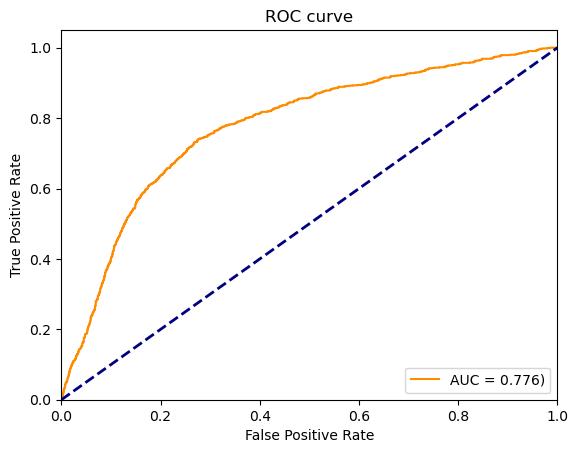

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

# Так у нашей модели дисбаланс классов мы будем использовать четыре разные техники для этого:
- Опция из под коробки 'class_weight' - который будет учитывать лучше дисбаланс классов
- Oversampling
- Undersampling
- SMOTE
По каждой отдельной техникой будет блок с информацией.В конце сравним результаты всех 5 видов модели включая 'Basline'

## class_weight

In [33]:
lg = LogisticRegression(class_weight='balanced', random_state=RAND)
lg.fit(X_train, y_train)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

new_metrics = get_metrics(y_test, y_pred, y_score, name='ClassWeight')

# Объединение старого DataFrame с новым
metrics = pd.concat([metrics, new_metrics], ignore_index=True)
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.769050,0.775954,0.567308,0.308901,0.400000,0.472777
1,ClassWeight,0.735647,0.775476,0.479403,0.706806,0.571308,0.575665


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

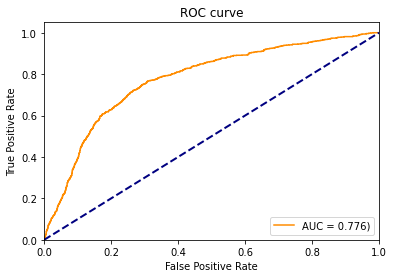

In [116]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[: , 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

## Oversampling

- Oversampling (пересемплирование) — это метод увеличения количества экземпляров меньшинства (миноритарного класса) путем создания копий существующих данных или генерации новых данных. Основная цель — сбалансировать количество экземпляров каждого класса.

- Преимущества:

Увеличивает представительство миноритарного класса.
Снижает вероятность переобучения, так как все классы имеют большее количество экземпляров.
- Недостатки:

Может привести к переобучению, особенно если просто дублировать экземпляры, так как модель может запомнить повторяющиеся экземпляры.
Увеличивает размер данных, что может повысить требования к памяти и времени обучения.


<img src='https://dataaspirant.com/wp-content/uploads/2020/08/10-oversampling.png'>

In [34]:
# метод для OverSampling
from imblearn.over_sampling import RandomOverSampler

In [35]:
# делаем размерности классов 1 к 1, если 0.6 - то размер недостающего класса
# составляет 60% от большего класса

oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [36]:
X_over.shape

(23008, 176)

In [37]:
X_train.shape

(15326, 176)

In [38]:
y_over.value_counts()

target
0.0    11504
1.0    11504
Name: count, dtype: int64

In [39]:
y_train.value_counts()

target
0.0    11504
1.0     3822
Name: count, dtype: int64

- Вывод результатов

In [41]:
lg = LogisticRegression(random_state=RAND)
lg.fit(X_over, y_over)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

new_metrics = get_metrics(y_test, y_pred, y_score, name='OverSampling')

# Объединение старого DataFrame с новым
metrics = pd.concat([metrics, new_metrics], ignore_index=True)

metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.769050,0.775954,0.567308,0.308901,0.400000,0.472777
1,ClassWeight,0.735647,0.775476,0.479403,0.706806,0.571308,0.575665
2,OverSampling,0.736430,0.776967,0.480399,0.705759,0.571671,0.573967


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

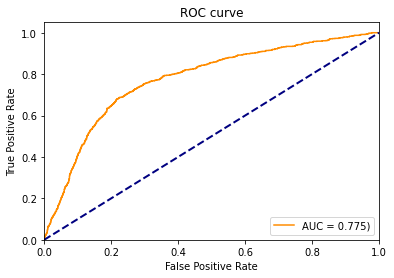

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

- Undersampling (недосемплирование) — это метод уменьшения количества экземпляров большинства (мажоритарного класса) путем случайного удаления данных. Основная цель — сбалансировать количество экземпляров каждого класса.

- Преимущества:

Уменьшает размер данных, что снижает требования к памяти и времени обучения.
Снижает вероятность переобучения на миноритарном классе.
- Недостатки:

Может приводить к потере важной информации из мажоритарного класса.
Может ухудшить производительность модели, если мажоритарный класс содержит важные признаки.

Undersampling – это дублирование примеров мажоритарного (наибольшего) класса. В зависимости от того, какое соотношение классов необходимо, выбирается количество случайных записей для дублирования.

<img src='https://dataaspirant.com/wp-content/uploads/2020/08/17-undersampling.png'>

In [42]:
# метод для UnderSampling
from imblearn.under_sampling import RandomUnderSampler

In [43]:
undersample = RandomUnderSampler(sampling_strategy=1.0) #sampling_strategy = majority
X_under, y_under = undersample.fit_resample(X_train, y_train)

In [44]:
X_under.shape

(7644, 176)

In [45]:
X_train.shape

(15326, 176)

In [46]:
y_under.value_counts()

target
0.0    3822
1.0    3822
Name: count, dtype: int64

- Выводим результаты

In [47]:
lg = LogisticRegression(random_state=RAND)
lg.fit(X_under, y_under)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)

new_metrics = get_metrics(y_test, y_pred, y_score, name='UnderSampling')

# Объединение старого DataFrame с новым
metrics = pd.concat([metrics, new_metrics], ignore_index=True)
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.769050,0.775954,0.567308,0.308901,0.400000,0.472777
1,ClassWeight,0.735647,0.775476,0.479403,0.706806,0.571308,0.575665
2,OverSampling,0.736430,0.776967,0.480399,0.705759,0.571671,0.573967
3,UnderSampling,0.736430,0.776765,0.480702,0.717277,0.575630,0.577732


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

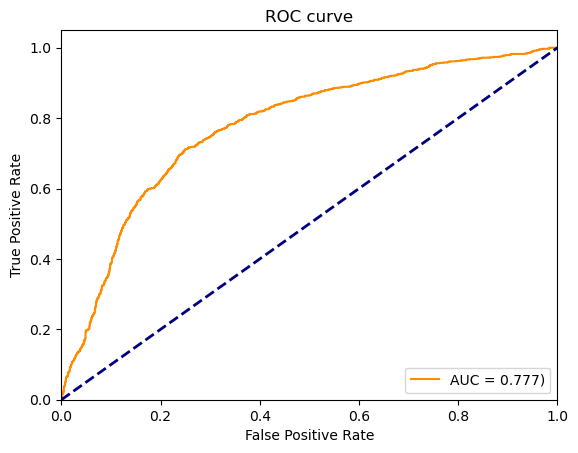

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[: ,1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

- SMOTE — это продвинутый метод пересемплирования, который синтетически генерирует новые экземпляры миноритарного класса, вместо того чтобы просто дублировать существующие. SMOTE создает новые данные, интерполируя между существующими экземплярами миноритарного класса.

- Преимущества:

Увеличивает разнообразие данных миноритарного класса.
Снижает вероятность переобучения, так как создает новые экземпляры, а не дублирует существующие.
- Недостатки:

Может создавать экземпляры, которые не являются репрезентативными для миноритарного класса.
Может усложнить модель, если синтетические данные не точно отражают распределение реальных данных.


In [49]:
from imblearn.over_sampling import SMOTE

In [50]:
smote = SMOTE(k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [51]:
y_train.value_counts()

target
0.0    11504
1.0     3822
Name: count, dtype: int64

In [52]:
y_smote.value_counts()

target
0.0    11504
1.0    11504
Name: count, dtype: int64

- Обучения модели

In [54]:
lg = LogisticRegression(random_state=RAND)
lg.fit(X_smote, y_smote)

y_pred = lg.predict(X_test)
y_score = lg.predict_proba(X_test)


new_metrics = get_metrics(y_test, y_pred, y_score, name='SMOTE')

# Объединение старого DataFrame с новым
metrics = pd.concat([metrics, new_metrics], ignore_index=True)
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,Baseline,0.769050,0.775954,0.567308,0.308901,0.400000,0.472777
1,ClassWeight,0.735647,0.775476,0.479403,0.706806,0.571308,0.575665
2,OverSampling,0.736430,0.776967,0.480399,0.705759,0.571671,0.573967
3,UnderSampling,0.736430,0.776765,0.480702,0.717277,0.575630,0.577732
4,SMOTE,0.751044,0.733686,0.500514,0.509948,0.505187,0.538469


- Выводим график под кривой ROC-AUC для визуальной оценки модели.

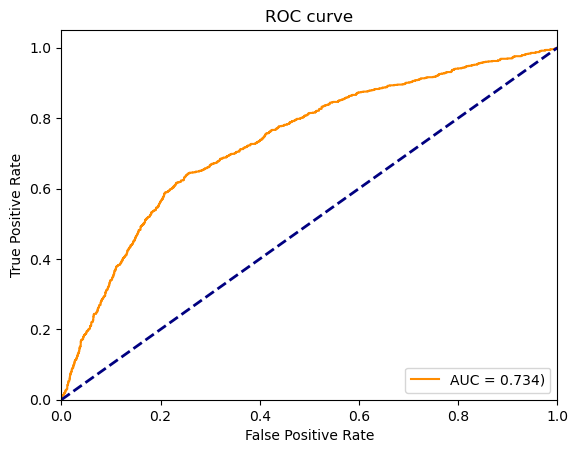

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])

# auc - Compute Area Under the Curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
# const алгоритм - прямая линия
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# масштаб
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

# где расположена легенда
plt.legend(loc="lower right")
plt.show()

Больше про SMOTE https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

# Results

In [60]:
metrics

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
Baseline,0.769050,0.775954,0.567308,0.308901,0.400000,0.472777
ClassWeight,0.735647,0.775476,0.479403,0.706806,0.571308,0.575665
OverSampling,0.736430,0.776967,0.480399,0.705759,0.571671,0.573967
UnderSampling,0.736430,0.776765,0.480702,0.717277,0.575630,0.577732
SMOTE,0.751044,0.733686,0.500514,0.509948,0.505187,0.538469


Вывод 
1. **Baseline модель**:
   - Имеет наибольшую точность (Accuracy) 0.7685 и наибольшую AUC (0.7748), но очень низкую полноту (Recall) 0.3131.
   - Низкий Recall означает, что модель плохо справляется с обнаружением положительных случаев, несмотря на высокую точность и AUC.

2. **ClassWeight**:
   - Умеренно сниженная точность (0.7356) по сравнению с базовой моделью.
   - Значительное улучшение Recall до 0.7037, что указывает на лучшее обнаружение положительных случаев.
   - Наибольший F1-Score (0.5702), что показывает баланс между Precision и Recall.
   - Небольшое увеличение Logloss (0.5757), что указывает на чуть худшую уверенность в предсказаниях.

3. **Oversampling**:
   - Точность немного ниже (0.7307) и AUC остается на уровне 0.7747.
   - Наивысший Recall (0.7162), что делает эту технику наиболее эффективной в обнаружении положительных случаев.
   - Снижение Precision (0.4734), что указывает на большее количество ложноположительных предсказаний.
   - F1-Score (0.5700) близок к ClassWeight, что также демонстрирует хороший баланс.

4. **Undersampling**:
   - Снижение точности (0.7325) и AUC (0.7731).
   - Высокий Recall (0.7026), схожий с ClassWeight.
   - Снижение Precision (0.4752), что указывает на большее количество ложноположительных предсказаний.
   - F1-Score (0.5670) также близок к ClassWeight.

5. **SMOTE**:
   - Точность (0.7495) и AUC (0.7464) ниже базовой модели, но выше по сравнению с другими методами обработки.
   - Средний Recall (0.4429) по сравнению с другими методами обработки.
   - Precision (0.4971) выше, чем у других методов обработки, что указывает на меньшее количество ложноположительных предсказаний.
   - Средний F1-Score (0.4684), что показывает баланс между Precision и Recall.
   - Самый низкий Logloss (0.5225), что указывает на наиболее уверенные предсказания.

### Итог:
- **ClassWeight** и **Oversampling** методы показывают лучшие результаты по F1-Score, что указывает на хороший баланс между Precision и Recall.
- **Oversampling** достигает наивысшего Recall, что делает его лучшим для задач, где важно обнаружение всех положительных случаев.
- **SMOTE** показывает самый низкий Logloss, что указывает на уверенные предсказания, но при этом имеет более низкий Recall.
- Выбор метода обработки данных зависит от конкретной задачи и приоритетов: если важен баланс, то ClassWeight и Oversampling являются хорошими выборами; если важны уверенные предсказания, то SMOTE может быть предпочтительным.